# Tuning Random Forest Classifier hyperparameters

In [22]:
import sys
sys.path.append('../')

import numpy as np
from sklearn.ensemble import RandomForestClassifier


from MRIsegm.utils import get_slice, get_slice_info, get_rois, make_mask
from MRIsegm.processing import denoise_slice
from MRIsegm.methods import features_extraction, definig_variables, print_metrics, show_model_result, save_model

## Loading data

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patience = 'BO11/'

# slice
dir_path =  src + patience + 'T2AX'
slice = get_slice(dir_path=dir_path) 
slice = denoise_slice(slice=slice, alpha=6) # denoising
get_slice_info(slice)

# ROIs
roi_path = src + patience + 'T2ROI'
positions, xs, ys = get_rois(roi_path=roi_path) 

The image object has the following dimensions: depth:30, height:512, width:512


## Features extraction

In [3]:
layer = 14

ksize = np.arange(3, 5, 1)
sigma = np.arange(1, 5, 1)
theta = np.arange(0, 2*np.pi, np.pi/4)
lamb = np.arange(0, 2*np.pi, np.pi/4)
gamma = np.arange(0, 1, 0.2)
psi = np.arange(0, 1, 1)

df = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

## Adding training layer

In [4]:
labels = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)
labels_vect = labels.reshape(-1)
df['labels'] = labels_vect

## Defining Variables

In [5]:
X_train, X_test, Y_train, Y_test = definig_variables(df, test_size=0.3, random_state=20)

## Random Hyperparam grid

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 350, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 35, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3]
# class_weight
class_weight = ['balanced', 'balanced_subsample']

### Create the random grid

In [7]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}

In [8]:
from pprint import pprint

pprint(random_grid)

{'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [20, 23, 27, 31, 35, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 237, 275, 312, 350]}


## Use the random grid to search for best hyperparameters

In [9]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, scoring = 'balanced_accuracy', random_state=42)

rf_random.fit(X_train, Y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END class_weight=balanced, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=312; total time= 1.5min
[CV] END class_weight=balanced, max_depth=23, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=312; total time= 1.5min
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time= 1.8min
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time= 1.9min
[CV] END class_weight=balanced_subsample, max_depth=31, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time= 1.8min
[CV] END class_weight=balanced_subsample, max_depth=31, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time= 1.9min
[CV] END class_weight=balanced_subsample,

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [20, 23, 27, 31, 35, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 237, 275, 312,
                                                         350]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

## Best Model

In [10]:
pprint(rf_random.best_params_)

best_model = rf_random.best_estimator_

{'class_weight': 'balanced_subsample',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 275}


## Evaluating model

In [11]:
prediction_test = best_model.predict(X_test)

In [12]:
print_metrics(Y_test=Y_test, prediction_test=prediction_test)

Accuracy =  0.9579243171761355
Balanced accuracy =  0.8710054863453466
f1_score (macro) =  0.6778243924709629
f1_score (micro) =  0.9579243171761355
homogeneity_score =  0.37312254243057685


## Test on image

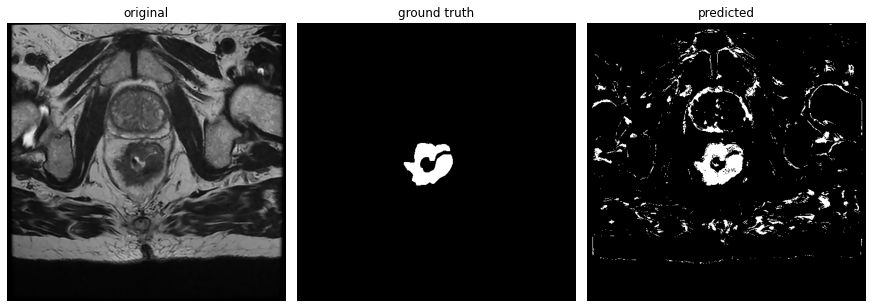

In [13]:
X = df.drop(labels= ['labels'], axis=1)


result = best_model.predict(X)
predicted = result.reshape(slice.shape[1:3])
ground_truth = labels

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## test on different image

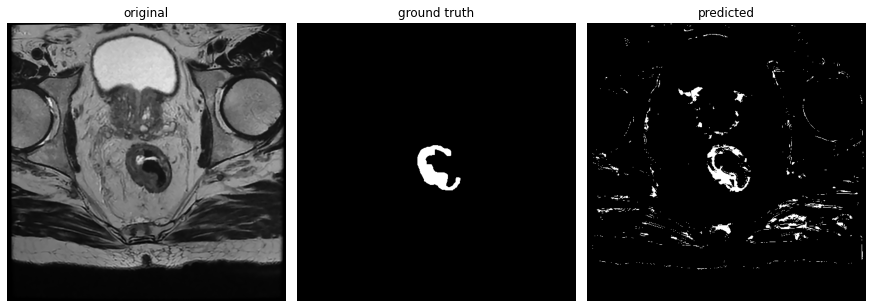

In [14]:
layer = 5

X = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = best_model.predict(X)
predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## Tuning bis

In [15]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [250, 275],
               'max_depth': [20, 25],
               'min_samples_split': [2, 3],
               'min_samples_leaf': [4, 5],
                'class_weight' : ['balanced', 'balanced_subsample'] }


In [16]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring="balanced_accuracy",
                          cv = 2, verbose = 2)

grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=250; total time= 1.2min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=250; total time= 1.2min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=275; total time= 1.3min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=275; total time= 1.3min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=3, n_estimators=250; total time= 1.2min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=3, n_estimators=250; total time= 1.2min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_samples_split=3, n_estimators=275; total time= 1.3min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=4, min_s

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [20, 25], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 275]},
             scoring='balanced_accuracy', verbose=2)

## Best params

In [17]:
pprint(grid_search.best_params_)
pprint(grid_search.score)

best_grid = grid_search.best_estimator_

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 275}
<bound method BaseSearchCV.score of GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [20, 25], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 275]},
             scoring='balanced_accuracy', verbose=2)>


### Metrics

In [18]:
prediction_test = best_grid.predict(X_test)
print_metrics(Y_test=Y_test, prediction_test=prediction_test)

Accuracy =  0.9578861705915264
Balanced accuracy =  0.8702202068574485
f1_score (macro) =  0.6774737417571957
f1_score (micro) =  0.9578861705915264
homogeneity_score =  0.3718026525180314


## Test on image

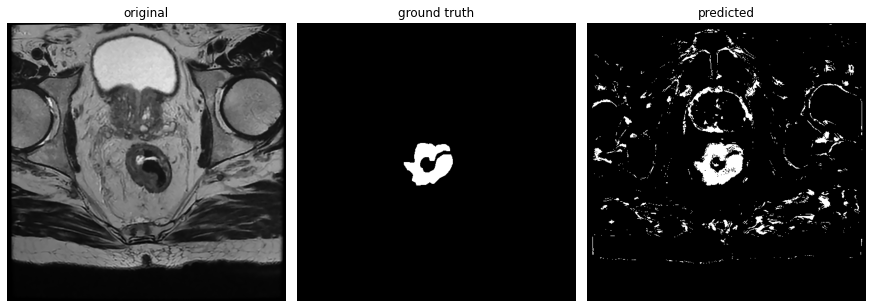

In [19]:
X = df.drop(labels= ['labels'], axis=1)


result = best_grid.predict(X)
predicted = result.reshape(slice.shape[1:3])
ground_truth = labels

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## Test on different image

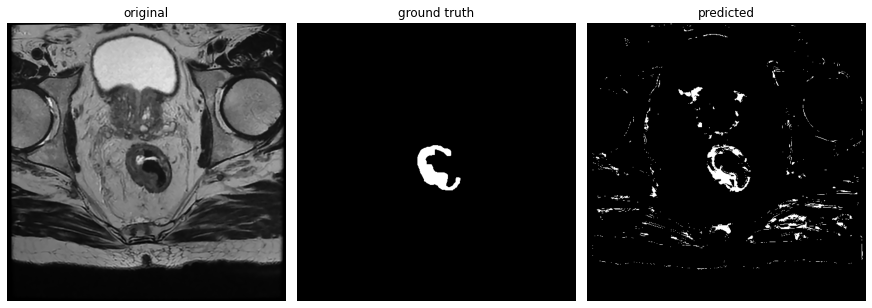

In [20]:
layer = 5

X = features_extraction(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, psi=psi)

result = best_grid.predict(X)
predicted = result.reshape(slice.shape[1:3])
ground_truth = make_mask(slice=slice, layer=layer, positions=positions, xs=xs, ys=ys)

show_model_result(ground_truth=ground_truth, predicted=predicted, show_original=True, original=slice[layer, : , :])

## comparing metrics

In [21]:
#random grid
rf_random_pred = best_model.predict(X_test)

print("RandomGridSearch metrics" , end='\n')
print_metrics(Y_test=Y_test, prediction_test=rf_random_pred)

#refined grid
print("GridSearch metrics", end='\n')
print_metrics(Y_test=Y_test, prediction_test=prediction_test)


RandomGridSearch metrics
Accuracy =  0.9579243171761355
Balanced accuracy =  0.8710054863453466
f1_score (macro) =  0.6778243924709629
f1_score (micro) =  0.9579243171761355
homogeneity_score =  0.37312254243057685
GridSearch metrics
Accuracy =  0.9578861705915264
Balanced accuracy =  0.8702202068574485
f1_score (macro) =  0.6774737417571957
f1_score (micro) =  0.9578861705915264
homogeneity_score =  0.3718026525180314


## Saving model

In [23]:
filename = 'tuned_model'
save_model(filename=filename, model=best_model)